## Pew Public Opinion: Summary Statistics Template

In order to better understand our data dispersion, we look to build out a summary report that allows us to automate a data description about a region of choice. Eventually this would be dynamic - an analyst can specify the exact extent of their summary query - and would be generated from within the dashboard. 

In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

In [2]:
pew = pd.read_csv("pew_processed.csv", index_col=0)
df = pew[pew['country'] == 'Australia']

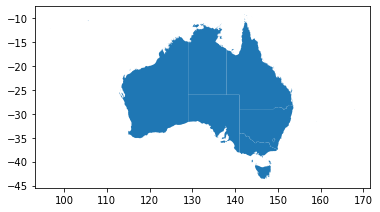

In [3]:
# full and simplified plots available. Use simplified, they are 10 fold smaller and are accurate enough for our use
aus = gpd.read_file("/Users/natalie_kraft/Downloads/geoBoundaries-AUS-ADM1-all/geoBoundaries-AUS-ADM1_simplified.geojson")
aus.plot()

In [4]:
aus

,shapeName,Level,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,External Territories,ADM1,None,AUS-ADM1-42912490B18435035,AUS,ADM1,"MULTIPOLYGON (((150.69476 -35.18468, 150.69566..."
1,Australian Capital Territory,ADM1,AU-ACT,AUS-ADM1-42912490B59156419,AUS,ADM1,"POLYGON ((148.77304 -35.56816, 148.78247 -35.5..."
2,New South Wales,ADM1,AU-NSW,AUS-ADM1-42912490B93132033,AUS,ADM1,"MULTIPOLYGON (((150.22628 -36.24313, 150.22318..."
3,Northern Territory,ADM1,AU-NT,AUS-ADM1-42912490B67131867,AUS,ADM1,"MULTIPOLYGON (((137.46267 -16.15698, 137.45778..."
4,Queensland,ADM1,AU-QLD,AUS-ADM1-42912490B41692690,AUS,ADM1,"MULTIPOLYGON (((153.41226 -27.93130, 153.41408..."
5,South Australia,ADM1,AU-SA,AUS-ADM1-42912490B62969644,AUS,ADM1,"MULTIPOLYGON (((140.56922 -38.02084, 140.56997..."
6,Tasmania,ADM1,AU-TAS,AUS-ADM1-42912490B92024026,AUS,ADM1,"MULTIPOLYGON (((146.37219 -43.74048, 146.37517..."
7,Victoria,ADM1,AU-VIC,AUS-ADM1-42912490B33360360,AUS,ADM1,"MULTIPOLYGON (((146.29448 -39.15608, 146.29348..."
8,Western Australia,ADM1,AU-WA,AUS-ADM1-42912490B59551795,AUS,ADM1,"MULTIPOLYGON (((117.60701 -35.12818, 117.60636..."


### Define which regions each location actually belongs to 

Use fuzzy string matching to grab the correct ADM1 boundary

In [5]:
from fuzzywuzzy import fuzz

In [6]:
# know that there is some ambiguity in ADM 1 to be grabbing
df.groupby('survey_year')['regional_location'].value_counts()

survey_year  regional_location                        
2017         Victoria                                     293
             New South Wales                              263
             Queensland                                   215
             Western Australia                             83
             South Australia                               75
             Tasmania                                      35
             Australian Capital Territory                  24
             Northern Territory                            12
2018         New South Wales (NSW)                        362
             Victoria (VIC)                               272
             Queensland (QLD)                             203
             Western Australia (WA)                       126
             South Australia (SA)                          79
             DK/Refused                                    59
             Tasmania (TAS)                                36
             No

In [7]:
def find_adm(adm_df, location_df, sim_threshold, update_dict, encode): 
    location_df.replace(update_dict, inplace=True)
    
    adm_dict = dict(zip(range(0, len(adm_df)), adm_df['shapeName']))
    location_df['fuzzy_matching'] = [[fuzz.partial_ratio(x, y) for x in adm_df['shapeName']] for y in location_df['regional_location']]
    location_df['adm1'] = [adm_dict[x.index(max(x))] if max(x) > sim_threshold else "Not found" for x in location_df['fuzzy_matching']]
    
    print("There are " + str(len(location_df[location_df['adm1'] == 'Not found'])) + " instances not identified")
    print("Here are the missing elements: ")
    print(set(location_df[location_df['adm1'] == 'Not found']['regional_location']))
    
    # take the 'adm1' column and map it with the adm1 code
    if encode: 
        print('--------------')
        print('encoding adm1_id codes')
    
        adm_id = dict(zip(adm_df['shapeName'], adm_df['shapeISO']))
        location_df['adm1_id'] = location_df['adm1'].map(adm_id)
        
    return location_df.drop(columns=['fuzzy_matching'])

In [8]:
# get the ADM name for all of the regional locations
# ignore 'Refused' and 'DK' values. They will only have location at the country level coded. 

# encode == True will go ahead and add the Adm1_id code to the dataframe. Its reccomended when testing the dataset
# you leave this as False
df = find_adm(aus, df, 80, {'Adelaide' : 'South Australia', 
                                 'Hobart' : 'Tasmania', 
                                 'Sydney' : 'New South Wales',
                                 'Brisbane' : 'Queensland',
                                 'Perth' : 'Western Australia',
                                 'Darwin' : 'Northern Territory',
                                 'Melbourne' : 'Victoria'}, True)

There are 60 instances not identified
Here are the missing elements: 
{'DK/Refused', 'Refused'}
--------------
encoding adm1_id codes


## Let's first look at some basic data descriptions

Process and output some information regarding demographics for the respondents. 

[Text(0, 0.5, 'Age-Group'),
 Text(0.5, 0, 'Public Opinion Respondent Distributions'),
 Text(0.5, 1.0, 'Population Pyramid')]

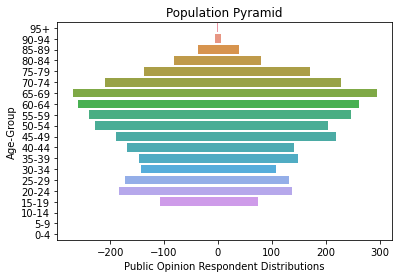

In [9]:
age = df.loc[(df['age'] != 'Refused') & (df['age'] != "Don't know") & (pd.notna(df['age']))]
age.replace({'97 or older': 98}, inplace=True)
age['age'] = age['age'].astype(int)
bins = list(range(0, 105, 5))
labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94','95+']
age['age_cat'] = pd.cut(x=age['age'], 
                       bins=bins, 
                       labels=labels)

age_df = age.groupby(['age_cat', 'sex'])['id'].count().unstack().reset_index()
age_df['Male'] = age_df['Male'] * -1

bar_plot = sns.barplot(x='Male', y='age_cat', data=age_df, order=age_df['age_cat'][::-1], lw=0)
bar_plot = sns.barplot(x='Female', y='age_cat', data=age_df, order=age_df['age_cat'][::-1], lw=0)

bar_plot.set(xlabel="Public Opinion Respondent Distributions", ylabel="Age-Group", title = "Population Pyramid")

In [10]:
# make sure we can clarify when the survey was conducted in any given year 

df['month'] = [x.split("/")[0] for x in df['qdate_s']]
df.groupby(['survey_year', 'month'])['id'].count()

# TODO: work on formatting so it becomes: Feb-Mar 2017, May-July 2018, etc

survey_year  month
2017         2        555
             3        445
2018         5        256
             6        744
             7        149
2019         6        432
             7        580
2020         6        454
             7        562
2021         3        330
             4        634
             5         35
Name: id, dtype: int64

Let's see about other patterns with religious, wealth and political affiliations. 

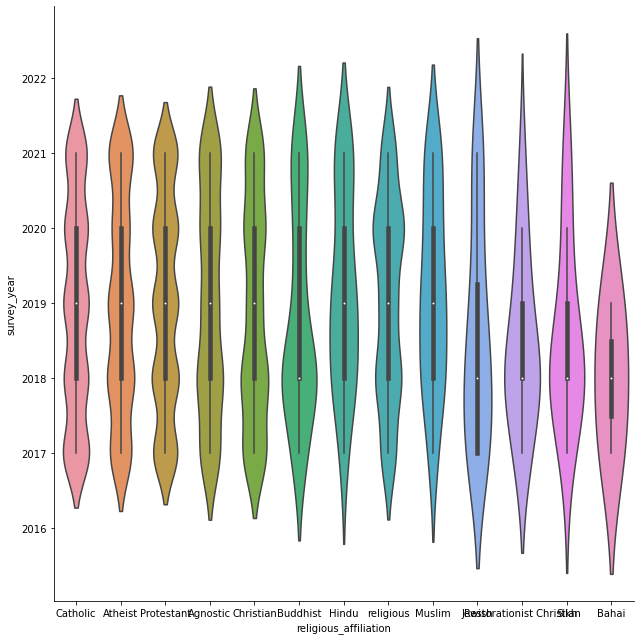

In [11]:
sns.catplot(x='religious_affiliation', y='survey_year', kind='violin', data=df, height=9)

In [12]:
df.groupby(['religious_affiliation'])['id'].count().reset_index().sort_values(by='id')

,religious_affiliation,id
2,Bahai,3
11,Sikh,9
10,Restorationist Christian,16
7,Jewish,24
6,Hindu,47
8,Muslim,50
3,Buddhist,77
12,religious,225
0,Agnostic,359
5,Christian,399


Text(0.5, 1.0, 'Relevant Political Affiliations and Growth')

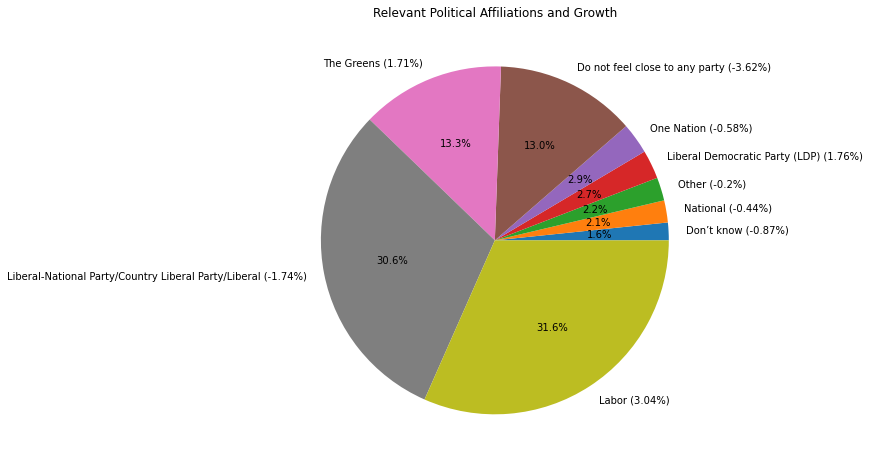

In [13]:
recent_pol = df[df['survey_year'] == 2021].groupby('political_affiliation')['id'].count().reset_index()
recent_pol['percent'] = [x * 100 / recent_pol['id'].sum() for x in recent_pol['id']]

pol_needed = recent_pol[recent_pol['percent'] > 1]['political_affiliation']

# restrict the rest of the graph to these most recent parties
all_pol = df.groupby(['political_affiliation', 'survey_year'])['id'].count().reset_index()
all_pol = all_pol[all_pol['political_affiliation'].isin(list(pol_needed.values))]

# get the percents to do the relative numbers
all_pol['percent'] = all_pol['id'] * 100 / all_pol.groupby('survey_year')['id'].transform('sum')
all_pol['change'] = all_pol['percent'] - all_pol.groupby('political_affiliation')['percent'].transform('mean')

# restrict to the most recent year 
graph = all_pol[all_pol['survey_year'] == 2021].sort_values(by='percent')
graph['political_affiliation_label'] = [x + " (" + str(round(y, 2)) + "%)" for x, y in zip(graph['political_affiliation'], graph['change'])]

plt.figure(figsize=(8,8))
plt.pie(graph['percent'], labels=graph['political_affiliation_label'], autopct='%1.1f%%')
plt.title("Relevant Political Affiliations and Growth")

In [14]:
df.groupby(['survey_year', 'wealthy'])['id'].count()

survey_year  wealthy                   
2017         $79,000 annually or above      64
             Less than $79,000 annually    107
             Refused                        44
2018         (Country median) or less       80
             More than (country median)     51
             Refused                        61
2019         $79,000 or less                61
             More than $79,000              42
             Refused                        38
2020         $79,000 or less                67
             More than $79,000              45
             Refused                        54
2021         $79,000 or less                57
             More than $79,000              41
             Refused                        28
Name: id, dtype: int64

Now, we can move onto to comparisons over time amongst common variables within the data sets. 

In [15]:
def binary_over_time_chart(df, group_by_var_1, group_by_var_2, final_var, var_1_label, var_2_label, not_binary, kind_p):
    
    var_1 = df.groupby(['survey_year', group_by_var_1])['id'].count().to_frame().reset_index()
    var_1['percent'] = var_1['id'] * 100 / var_1.groupby('survey_year')['id'].transform('sum')
    var_1[group_by_var_1].replace({0: var_1_label[0], 1: var_1_label[1]}, inplace=True)
    var_1.rename(columns={group_by_var_1:final_var}, inplace=True)
    
    if not_binary: 
        var_2 = df.groupby(['survey_year', group_by_var_2])['id'].count().to_frame().reset_index()
        var_2['percent'] = var_2['id'] * 100 / var_2.groupby('survey_year')['id'].transform('sum')
        var_2[group_by_var_2].replace({0:var_2_label[0], 1: var_2_label[1]}, inplace=True)
        var_2.rename(columns={group_by_var_2:final_var}, inplace=True)

        var = var_1.append(var_2)
    else: 
        var = var_1

    sns.catplot(x="survey_year", y="percent", hue=final_var, data=var, kind = kind_p)

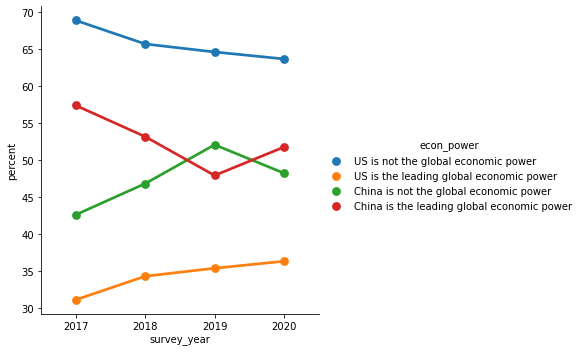

In [16]:
# econ_power US/China comparison

binary_over_time_chart(df, 'us_econ_power', 'china_econ_power', 'econ_power',
                ('US is not the global economic power', 'US is the leading global economic power'), 
                ('China is not the global economic power', 'China is the leading global economic power'), 
                True, "point")

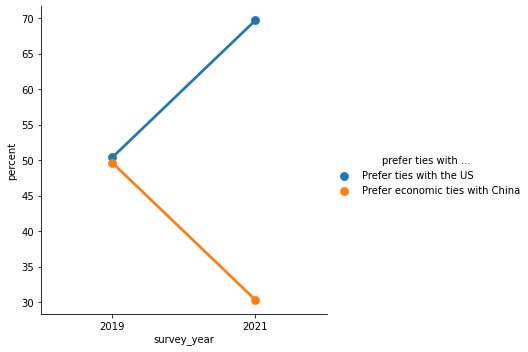

In [17]:
# prefer China/US economic power

binary_over_time_chart(df, 'prefer_china_econ', 'prefer_us_econ', 'prefer ties with ...',
                ('Prefer ties with the US', 'Prefer economic ties with China'), 
                ('Prefer ties with not US', 'Prefer economic ties with US'), False, 'point')

In [63]:
def compare_over_time_chart(df, group_by_var_1, final_var, kind_p):
    
    var_1 = df.groupby(['survey_year', group_by_var_1])['id'].count().to_frame().reset_index()
    var_1['percent'] = var_1['id'] * 100 / var_1.groupby('survey_year')['id'].transform('sum')
    
    # find the mapping convention 
    col = list(df.filter(regex=group_by_var_1, axis=1).columns)
    if len(col[0]) > len(col[1]): 
        col = col[::-1]
    df_dict = df.loc[pd.notna(df[col[0]]) & pd.notna(df[col[1]])]
    
    dict_var = dict(zip(df_dict[col[0]], df_dict[col[1]]))
    
    var_1[group_by_var_1].replace(dict_var, inplace=True)
    var_1.rename(columns={group_by_var_1:final_var}, inplace=True)
    
    sns.catplot(x="survey_year", y="percent", hue=final_var, data=var_1, kind = kind_p)

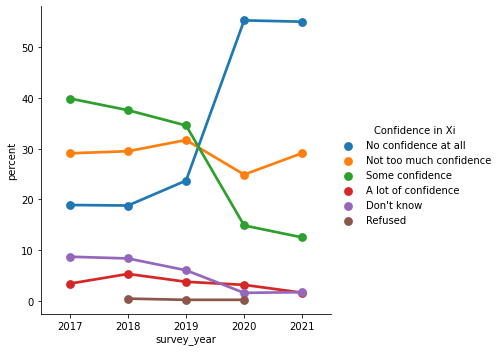

In [64]:
compare_over_time_chart(df, 'confid_xi', 'Confidence in Xi', "point")

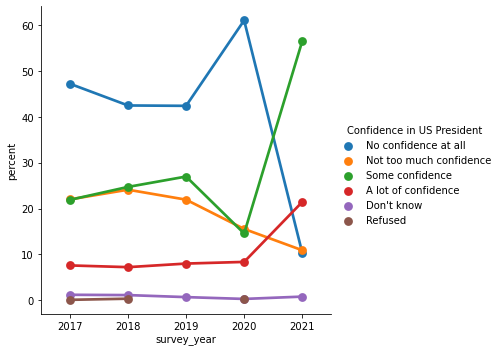

In [65]:
compare_over_time_chart(df, 'confid_uspres', 'Confidence in US President', "point")

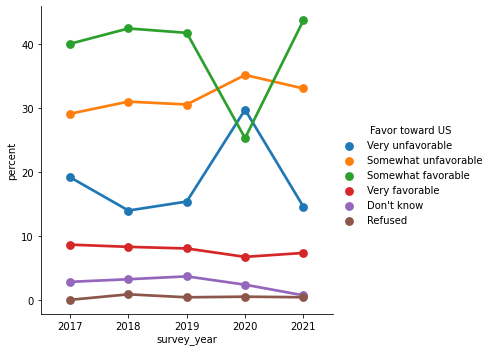

In [20]:
compare_over_time_chart(df, 'fav_us', 'Favor toward US', "point")

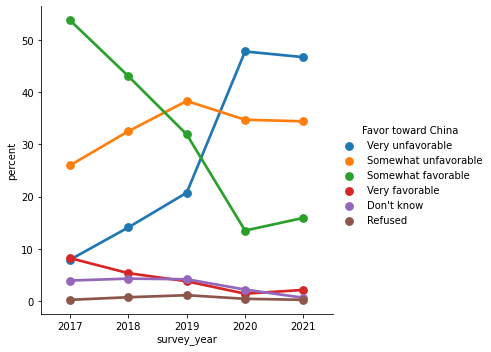

In [21]:
compare_over_time_chart(df, 'fav_china', 'Favor toward China', "point")

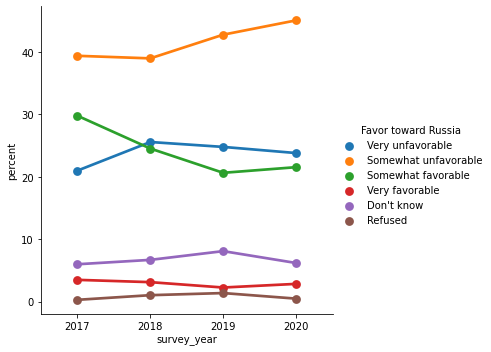

In [22]:
compare_over_time_chart(df, 'fav_russia', 'Favor toward Russia', "point")

In [23]:
# determine all the variables that this dataset (spatially restricted) 
# have that we want to learn about moving forward.
list(df.dropna(axis=1, how='all').columns)

['survey_year',
 'country',
 'id',
 'id_survey',
 'regional_location',
 'qdate_s',
 'sex',
 'male',
 'age',
 'd_hhpeople',
 'd_adult_us',
 'wealthy',
 'political_affiliation',
 'religious_affiliation',
 'education_level',
 'us_econ_power',
 'china_econ_power',
 'japan_econ_power',
 'eu_econ_power',
 'other_econ_power',
 'prefer_us_econ',
 'prefer_china_econ',
 'children_betteroff',
 'confid_uspres: How much confidence you have in the U.S. President to do the right thing regarding world affairs? ',
 'confid_uspres',
 'us_threat',
 'china_threat',
 'fav_us',
 'fav_china',
 'fav_russia',
 'country_satis',
 'satisfied_democracy',
 'confid_xi',
 'confid_putin',
 'econ_sit',
 'religion_import',
 'respect_china',
 'respect_us',
 'improve_econ',
 'intthreat_econcondition',
 'us_relationship',
 'china_econ',
 'china_military',
 'children_betteroff: When children today in (survey country) grow up, do you think they will be better off or worse off financially than their parents?',
 'fav_us: I am 

## To analyze, port to ArcGIS and call feature layer

In [ ]:
# to pass along to Joe 

#df.to_csv("aus_pew_sample.csv")
#aus.to_file("aus_boundaries_sample.geojson", driver='GeoJSON')

In [24]:
df.head()

,survey_year,country,id,id_survey,regional_location,qdate_s,sex,male,age,d_hhpeople,...,econsys_reform: Do you think that the economic system of (survey country) needs to be reformed?,china_tough_econ: Is it more important to be tough on China's territorial disputes or build a strong economic relationship with them?,russia_threat: Is Russia's power and influence a threat to your country?,china_influence: How much influence does the China exert on other countries?,us_influence: How much influence does the U.S. exert on other countries?,polsys_reform: Do you think that the political system of (survey country) needs to be reformed?,econ_ties_usch: How do you view current economic ties between the U.S. and China?,adm1,adm1_id,month
10110,2021,Australia,10111,3000013,"New South Wales (NSW), excluding Sydney",3/20/21,Male,1,55,4,...,It needs minor changes,NaN,NaN,NaN,NaN,It needs minor changes,NaN,New South Wales,AU-NSW,3
10111,2021,Australia,10112,3000442,"New South Wales (NSW), excluding Sydney",3/30/21,Male,1,60,6,...,It needs minor changes,NaN,NaN,NaN,NaN,It needs major changes,NaN,New South Wales,AU-NSW,3
10112,2021,Australia,10113,3000802,"Victoria (VIC), excluding Melbourne",3/30/21,Female,0,67,4,...,It needs major changes,NaN,NaN,NaN,NaN,It needs major changes,NaN,Victoria,AU-VIC,3
10113,2021,Australia,10114,3000890,"Victoria (VIC), excluding Melbourne",3/20/21,Male,1,26,4,...,It needs minor changes,NaN,NaN,NaN,NaN,It needs major changes,NaN,Victoria,AU-VIC,3
10114,2021,Australia,10115,3001051,"Victoria (VIC), excluding Melbourne",4/8/21,Female,0,66,3,...,It needs minor changes,NaN,NaN,NaN,NaN,It needs major changes,NaN,Victoria,AU-VIC,4


In [53]:
df.filter(regex='confid_uspres', axis=1)

,confid_uspres: How much confidence you have in the U.S. President to do the right thing regarding world affairs?,confid_uspres
10110,Not too much confidence,2
10111,Some confidence,3
10112,Some confidence,3
10113,A lot of confidence,4
10114,Some confidence,3
...,...,...
116543,NaN,1
116544,NaN,4
116545,NaN,2
116546,NaN,3


In [61]:
pew.groupby(['survey_year', 'country'])['confid_uspres: How much confidence you have in the U.S. President to do the right thing regarding world affairs? '].count()[100:150]

survey_year  country       
2020         Belgium            801
             Canada            1037
             Denmark           1043
             France            1051
             Germany           1016
             Italy             1002
             Japan             1056
             Netherlands       1000
             South Korea       1191
             Spain             1041
             Sweden            1016
             United Kingdom    1003
             United States     1003
2021         Australia          999
             Belgium           1006
             Canada            1010
             England              8
             France             985
             Germany           1027
             Greece            1032
             Italy             1003
             Japan             1014
             Netherlands       1005
             New Zealand       1000
             Scotland             2
             Singapore         1124
             South Korea       1006
